In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.stats import pearsonr 
%matplotlib inline

import math

def sample_queries(df, frac):
    srch_ids = pd.Series(df["srch_id"].unique()).sample(frac=frac, random_state=42)
    return df.loc[df.srch_id.isin(srch_ids)]

train = pd.read_csv("data/training_set_VU_DM_2014.csv")
#test = pd.read_csv("data/test_set_VU_DM_2014.csv")

train = sample_queries(train, 0.1)

train.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
86,11,2013-02-25 08:39:33,5,219,NaN,NaN,219,6492,2,4.0,...,NaN,NaN,NaN,NaN,1.0,0.0,12.0,0,NaN,0
87,11,2013-02-25 08:39:33,5,219,NaN,NaN,219,8946,3,4.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
88,11,2013-02-25 08:39:33,5,219,NaN,NaN,219,9952,2,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
89,11,2013-02-25 08:39:33,5,219,NaN,NaN,219,19470,2,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
90,11,2013-02-25 08:39:33,5,219,NaN,NaN,219,20499,2,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,1,NaN,0


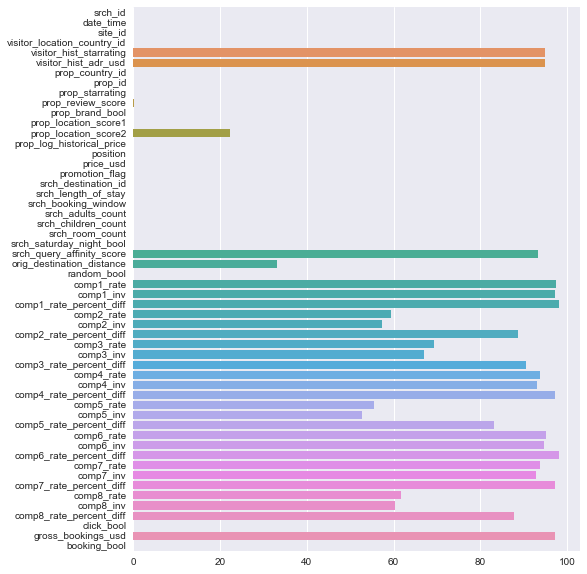

In [2]:
# Missing values
m = train.isnull().sum() / len(train) * 100
plt.figure(figsize=(8, 10))
sns.barplot(x=m.values, y=m.keys())

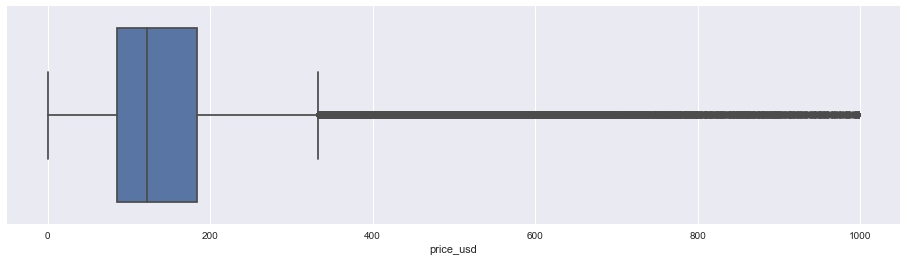

In [3]:
# Price distribution
plt.figure(figsize=(16, 4))
sns.boxplot(x=train.loc[train.price_usd < 1000].price_usd)

In [4]:
train.price_usd.max()

205182.0

In [5]:
(train.price_usd > 1000).mean()

0.0027166997248962805

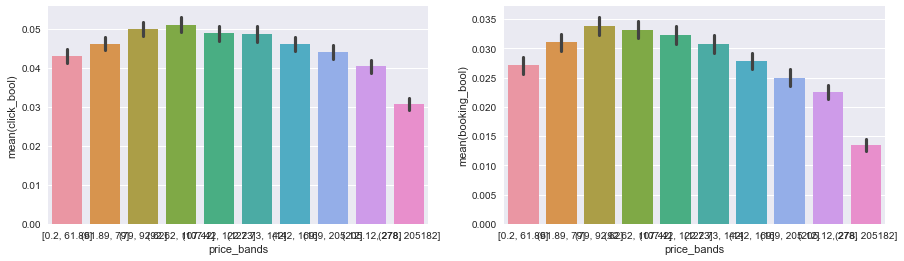

In [6]:
train["price_bands"] = pd.qcut(train.price_usd, 10)
#g = train.groupby("price_bands")

fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,4))
sns.barplot(x="price_bands", y="click_bool", data=train, ax=axis1)
sns.barplot(x="price_bands", y="booking_bool", data=train, ax=axis2)

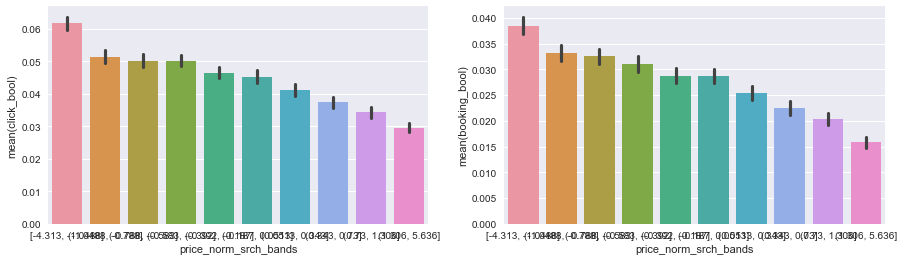

In [7]:
# Normalize prices by srch_id
train["price_norm_srch"] = train.groupby("srch_id")["price_usd"].transform(lambda x: (x - x.mean()) / x.std())
train["price_norm_srch_bands"] = pd.qcut(train.price_norm_srch, 10)

fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,4))
sns.barplot(x="price_norm_srch_bands", y="click_bool", data=train, ax=axis1)
sns.barplot(x="price_norm_srch_bands", y="booking_bool", data=train, ax=axis2)

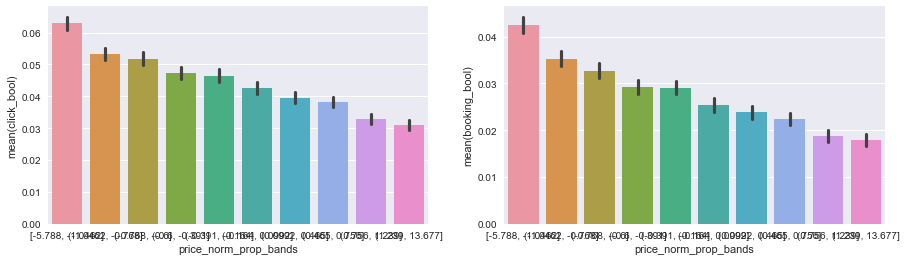

In [8]:
# Normalize prices by prop_id
train["price_norm_prop"] = train.groupby("prop_id")["price_usd"].transform(lambda x: (x - x.mean()) / x.std())
train["price_norm_prop_bands"] = pd.qcut(train.price_norm_prop, 10)

fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,4))
sns.barplot(x="price_norm_prop_bands", y="click_bool", data=train, ax=axis1)
sns.barplot(x="price_norm_prop_bands", y="booking_bool", data=train, ax=axis2)

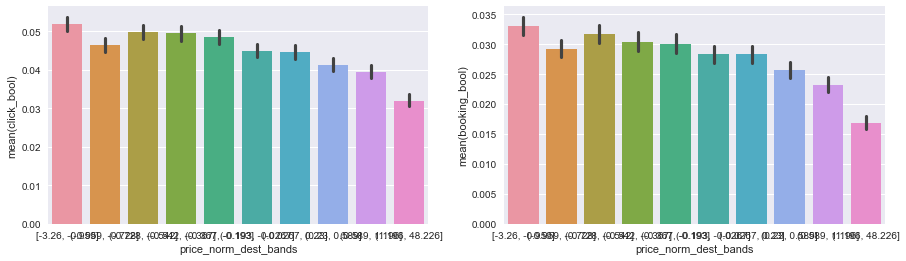

In [9]:
# Normalize prices by both srch_destination_id
train["price_norm_dest"] = train.groupby("srch_destination_id")["price_usd"].transform(lambda x: (x - x.mean()) / x.std())
train["price_norm_dest_bands"] = pd.qcut(train.price_norm_dest, 10)

fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,4))
sns.barplot(x="price_norm_dest_bands", y="click_bool", data=train, ax=axis1)
sns.barplot(x="price_norm_dest_bands", y="booking_bool", data=train, ax=axis2)

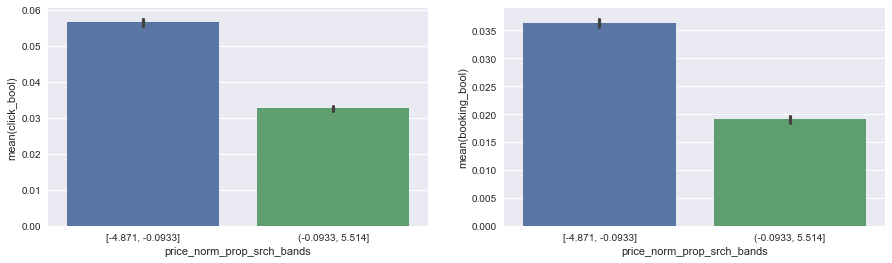

In [41]:
#Normalize prices by prop_id AND srch_id
train["price_norm_prop_srch"] = train.groupby("srch_id")["price_norm_prop"].transform(lambda x: (x - x.mean()) / x.std())
train["price_norm_prop_srch_bands"] = pd.qcut(train.price_norm_prop_srch, 10)

fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,4))
sns.barplot(x="price_norm_prop_srch_bands", y="click_bool", data=train, ax=axis1)
sns.barplot(x="price_norm_prop_srch_bands", y="booking_bool", data=train, ax=axis2)

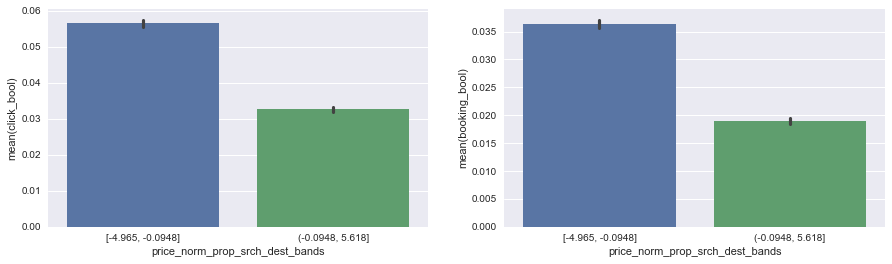

In [42]:
#Normalize prices by prop_id AND srch_id AND dest_id
train["price_norm_prop_srch_dest"] = train.groupby("srch_destination_id")["price_norm_prop_srch"].transform(lambda x: (x - x.mean()) / x.std())
train["price_norm_prop_srch_dest_bands"] = pd.qcut(train.price_norm_prop_srch_dest, 10)

fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,4))
sns.barplot(x="price_norm_prop_srch_dest_bands", y="click_bool", data=train, ax=axis1)
sns.barplot(x="price_norm_prop_srch_dest_bands", y="booking_bool", data=train, ax=axis2)

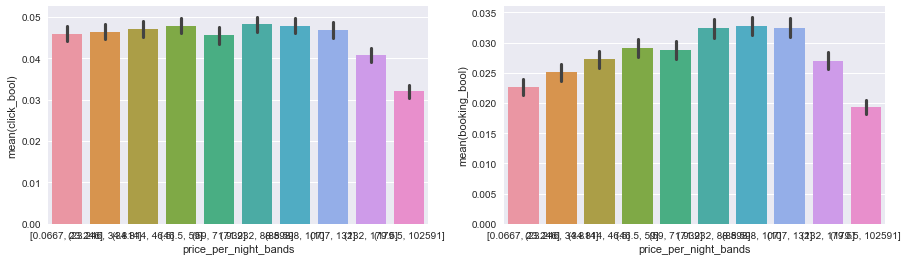

In [26]:
# Price per night
train["price_per_night"] = train.price_usd / train.srch_length_of_stay
train["price_per_night_bands"] = pd.qcut(train.price_per_night, 10)

fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,4))
sns.barplot(x="price_per_night_bands", y="click_bool", data=train, ax=axis1)
sns.barplot(x="price_per_night_bands", y="booking_bool", data=train, ax=axis2)

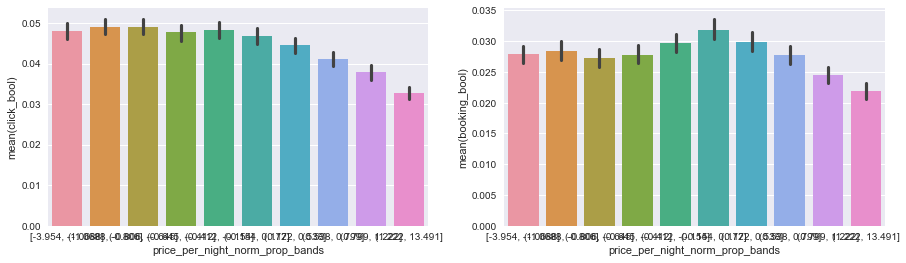

In [27]:
# Price per night normalized
train["price_per_night_norm_prop"] = train.groupby("prop_id")["price_per_night"].transform(lambda x: (x - x.mean()) / x.std())
train["price_per_night_norm_prop_bands"] = pd.qcut(train.price_per_night_norm_prop, 10)

fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,4))
sns.barplot(x="price_per_night_norm_prop_bands", y="click_bool", data=train, ax=axis1)
sns.barplot(x="price_per_night_norm_prop_bands", y="booking_bool", data=train, ax=axis2)

149.53


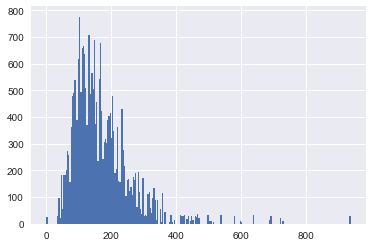

In [10]:
train.visitor_hist_adr_usd.hist(bins=250)
print(train.visitor_hist_adr_usd.median())

3.5


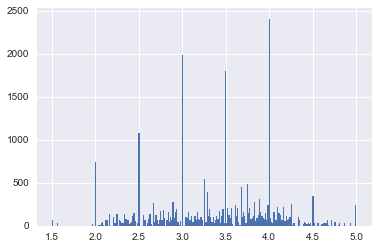

In [11]:
train.visitor_hist_starrating.hist(bins=250)
print(train.visitor_hist_starrating.median())

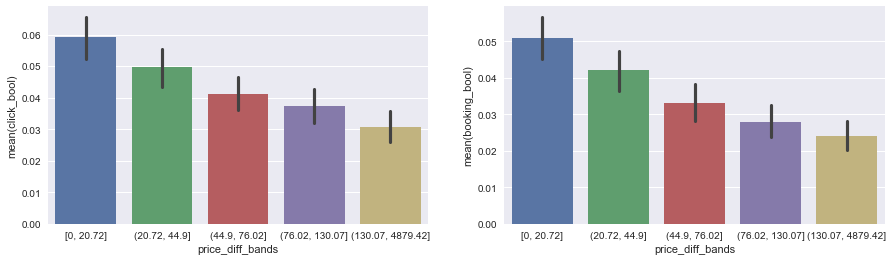

In [34]:
# Price difference between historical price and current price
train["price_diff"] = abs(train.visitor_hist_adr_usd - train.price_usd) #- train.price_usd.map(lambda x: 0 if x == 0 else math.log(x, 10)))
train["price_diff_bands"] = pd.qcut(train.price_diff, 5)

fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,4))
sns.barplot(x="price_diff_bands", y="click_bool", data=train, ax=axis1)
sns.barplot(x="price_diff_bands", y="booking_bool", data=train, ax=axis2)

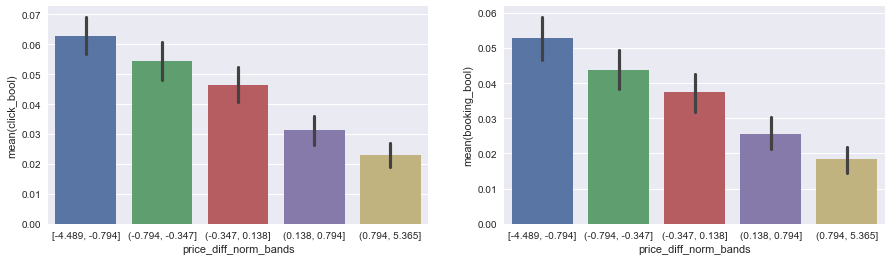

In [37]:
train["price_diff_norm"] = train.groupby("srch_id")["price_diff"].transform(lambda x: (x - x.mean()) / x.std())
train["price_diff_norm_bands"] = pd.qcut(train.price_diff_norm, 5)

fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,4))
sns.barplot(x="price_diff_norm_bands", y="click_bool", data=train, ax=axis1)
sns.barplot(x="price_diff_norm_bands", y="booking_bool", data=train, ax=axis2)

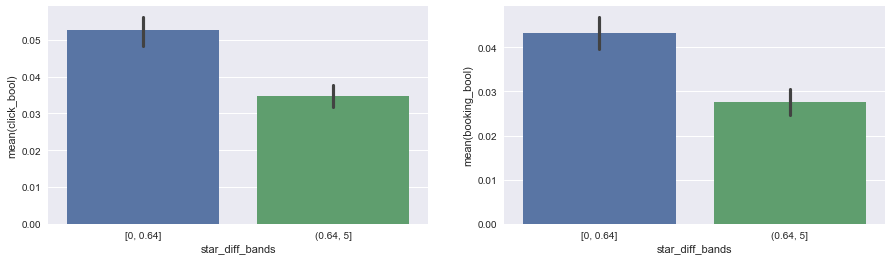

In [69]:
train["star_diff"] = abs(train.visitor_hist_starrating - train.prop_starrating)
train["star_diff_bands"] = pd.qcut(train.star_diff, 5)

fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,4))
sns.barplot(x="star_diff_bands", y="click_bool", data=train, ax=axis1)
sns.barplot(x="star_diff_bands", y="booking_bool", data=train, ax=axis2)

In [13]:
train["free"] = train["price_usd"].map(lambda x: 1 if x == 0 else 0)

fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,4))
sns.barplot(x="free", y="click_bool", data=train, ax=axis1)
sns.barplot(x="free", y="booking_bool", data=train), ax=axis2)

SyntaxError: invalid syntax (<ipython-input-13-e07bd94ee044>, line 5)

In [ ]:
train[["price_norm_srch", "price_norm_prop", "price_norm_dest"]].head()

In [49]:
train.columns

Index(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id',
       'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'position', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score',
       'orig_destination_distance', 'random_bool', 'comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate'

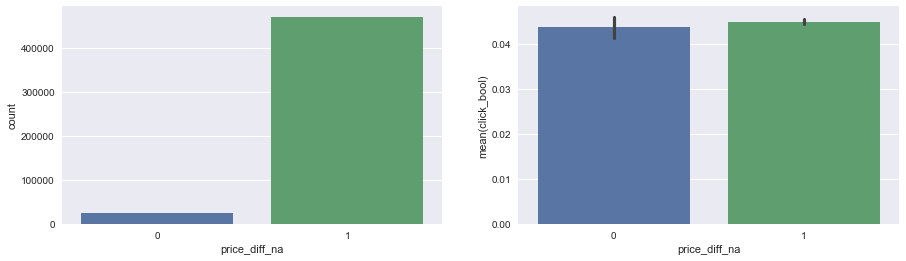

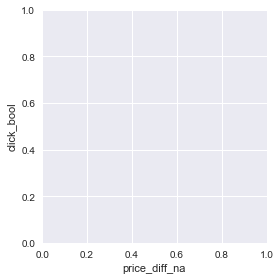

In [61]:
train["price_diff_na"] = train.price_diff.map(lambda x: 1 if pd.isnull(x) else 0)

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.countplot(x="price_diff_na", data=train, ax=axis1)
sns.factorplot(x="price_diff_na", y="click_bool", data=train, kind="bar", ax=axis2)